# Kaggle Project: Covid-19 Awareness and Covid-19 Cases in Ohio
# Date: Tuesday, April 9th, 2024

In [1]:
# IMPORTS
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import (explained_variance_score, mean_absolute_error,
                             mean_squared_error, mean_squared_log_error,
                             median_absolute_error, r2_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

# Exploratory Data Analysis (EDA)

In [2]:
# LOADING TRAINING DATA
df_train = pd.read_csv("/Users/eugeneayonga/Desktop/training_data.csv")
pd.get_option("display.max_columns")
pd.set_option("display.max_columns", None)
df_train.head()

,county,cases,deaths,date_index_converted,county_data_length,core_jaccard,core_cosine,core_intersection,social_jaccard,politics_jaccard,politics_democratic_love_jaccard,nationalistic_jaccard,politics_republican_hate_jaccard,entertainment_jaccard,sports_jaccard,race_jaccard,economy_jaccard,foreign_jaccard,religion_jaccard,health_jaccard,politics_republican_love_jaccard,health_technology_jaccard,politics_democratic_hate_jaccard,domestic_jaccard,illness_jaccard,ideology_jaccard,education_jaccard,gender_jaccard,social_cosine,politics_cosine,politics_democratic_love_cosine,nationalistic_cosine,politics_republican_hate_cosine,entertainment_cosine,sports_cosine,race_cosine,economy_cosine,foreign_cosine,religion_cosine,health_cosine,politics_republican_love_cosine,health_technology_cosine,politics_democratic_hate_cosine,domestic_cosine,illness_cosine,ideology_cosine,education_cosine,gender_cosine,social_intersection,politics_intersection,politics_democratic_love_intersection,nationalistic_intersection,politics_republican_hate_intersection,entertainment_intersection,sports_intersection,race_intersection,economy_intersection,foreign_intersection,religion_intersection,health_intersection,politics_republican_love_intersection,health_technology_intersection,politics_democratic_hate_intersection,domestic_intersection,illness_intersection,ideology_intersection,education_intersection,gender_intersection,core_jaccard_normalized,core_cosine_normalized,core_intersection_normalized,ideology_jaccard_normalized,race_jaccard_normalized,economy_jaccard_normalized,sports_jaccard_normalized,foreign_jaccard_normalized,domestic_jaccard_normalized,nationalistic_jaccard_normalized,politics_democratic_love_jaccard_normalized,health_technology_jaccard_normalized,education_jaccard_normalized,gender_jaccard_normalized,religion_jaccard_normalized,social_jaccard_normalized,politics_republican_love_jaccard_normalized,politics_jaccard_normalized,entertainment_jaccard_normalized,politics_republican_hate_jaccard_normalized,politics_democratic_hate_jaccard_normalized,health_jaccard_normalized,illness_jaccard_normalized,ideology_cosine_normalized,race_cosine_normalized,economy_cosine_normalized,sports_cosine_normalized,foreign_cosine_normalized,domestic_cosine_normalized,nationalistic_cosine_normalized,politics_democratic_love_cosine_normalized,health_technology_cosine_normalized,education_cosine_normalized,gender_cosine_normalized,religion_cosine_normalized,social_cosine_normalized,politics_republican_love_cosine_normalized,politics_cosine_normalized,entertainment_cosine_normalized,politics_republican_hate_cosine_normalized,politics_democratic_hate_cosine_normalized,health_cosine_normalized,illness_cosine_normalized,ideology_intersection_normalized,race_intersection_normalized,economy_intersection_normalized,sports_intersection_normalized,foreign_intersection_normalized,domestic_intersection_normalized,nationalistic_intersection_normalized,politics_democratic_love_intersection_normalized,health_technology_intersection_normalized,education_intersection_normalized,gender_intersection_normalized,religion_intersection_normalized,social_intersection_normalized,politics_republican_love_intersection_normalized,politics_intersection_normalized,entertainment_intersection_normalized,politics_republican_hate_intersection_normalized,politics_democratic_hate_intersection_normalized,health_intersection_normalized,illness_intersection_normalized,total_pop,percent_25_34,percent_highschool,labor_force_rate,unemployment_rate,median_housing_cost,median_household_earnings,median_worker_earnings,percent_insured,percent_married,poverty_rate,median_property_value,percent_white
0,Richland,0,0,day_10,363,0.000000,0.00000,0.000000,0.000011,0.000151,0.000053,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000125,0.0,0.0,0.000047,0.00000,0.0,0.000000,0.0,0.000054,0.000902,0.000154,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000356,0.0,0.0,0.000522,0.000000,0.0,0.000000,0

In [3]:
# Missing values, filtering columns with null values
len(df_train.isnull().sum()[lambda x: x > 0])

0

In [4]:
# Training data shape
df_train.shape

(3141, 144)

In [5]:
# Statistical summary --> training data
df_train.describe()

,cases,deaths,county_data_length,core_jaccard,core_cosine,core_intersection,social_jaccard,politics_jaccard,politics_democratic_love_jaccard,nationalistic_jaccard,politics_republican_hate_jaccard,entertainment_jaccard,sports_jaccard,race_jaccard,economy_jaccard,foreign_jaccard,religion_jaccard,health_jaccard,politics_republican_love_jaccard,health_technology_jaccard,politics_democratic_hate_jaccard,domestic_jaccard,illness_jaccard,ideology_jaccard,education_jaccard,gender_jaccard,social_cosine,politics_cosine,politics_democratic_love_cosine,nationalistic_cosine,politics_republican_hate_cosine,entertainment_cosine,sports_cosine,race_cosine,economy_cosine,foreign_cosine,religion_cosine,health_cosine,politics_republican_love_cosine,health_technology_cosine,politics_democratic_hate_cosine,domestic_cosine,illness_cosine,ideology_cosine,education_cosine,gender_cosine,social_intersection,politics_intersection,politics_democratic_love_intersection,nationalistic_intersection,politics_republican_hate_intersection,entertainment_intersection,sports_intersection,race_intersection,economy_intersection,foreign_intersection,religion_intersection,health_intersection,politics_republican_love_intersection,health_technology_intersection,politics_democratic_hate_intersection,domestic_intersection,illness_intersection,ideology_intersection,education_intersection,gender_intersection,core_jaccard_normalized,core_cosine_normalized,core_intersection_normalized,ideology_jaccard_normalized,race_jaccard_normalized,economy_jaccard_normalized,sports_jaccard_normalized,foreign_jaccard_normalized,domestic_jaccard_normalized,nationalistic_jaccard_normalized,politics_democratic_love_jaccard_normalized,health_technology_jaccard_normalized,education_jaccard_normalized,gender_jaccard_normalized,religion_jaccard_normalized,social_jaccard_normalized,politics_republican_love_jaccard_normalized,politics_jaccard_normalized,entertainment_jaccard_normalized,politics_republican_hate_jaccard_normalized,politics_democratic_hate_jaccard_normalized,health_jaccard_normalized,illness_jaccard_normalized,ideology_cosine_normalized,race_cosine_normalized,economy_cosine_normalized,sports_cosine_normalized,foreign_cosine_normalized,domestic_cosine_normalized,nationalistic_cosine_normalized,politics_democratic_love_cosine_normalized,health_technology_cosine_normalized,education_cosine_normalized,gender_cosine_normalized,religion_cosine_normalized,social_cosine_normalized,politics_republican_love_cosine_normalized,politics_cosine_normalized,entertainment_cosine_normalized,politics_republican_hate_cosine_normalized,politics_democratic_hate_cosine_normalized,health_cosine_normalized,illness_cosine_normalized,ideology_intersection_normalized,race_intersection_normalized,economy_intersection_normalized,sports_intersection_normalized,foreign_intersection_normalized,domestic_intersection_normalized,nationalistic_intersection_normalized,politics_democratic_love_intersection_normalized,health_technology_intersection_normalized,education_intersection_normalized,gender_intersection_normalized,religion_intersection_normalized,social_intersection_normalized,politics_republican_love_intersection_normalized,politics_intersection_normalized,entertainment_intersection_normalized,politics_republican_hate_intersection_normalized,politics_democratic_hate_intersection_normalized,health_intersection_normalized,illness_intersection_normalized,total_pop,percent_25_34,percent_highschool,labor_force_rate,unemployment_rate,median_housing_cost,median_household_earnings,median_worker_earnings,percent_insured,percent_married,poverty_rate,median_property_value,percent_white
count,3141.000000,3141.00000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.

In [6]:
# Cleaning column names
df_train.columns = [col.strip() for col in df_train.columns]

# Part I: Descriptive Analysis

### Summary of the Covid-19 experience in Ohio: https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Ohio

The first Covid-19 cases appeared in Ohio on March 9th, 2020, with the first death soon following on March 19th. Investigations later showed the virus was spreading earlier, with the first actual death likely in mid-March. By April, deaths were in the hundreds, and by May, they had passed 1,000. Limited testing made getting accurate numbers difficult. By December 2020, there were over half a million cases, with thousands needing hospitalization and over 7,000 deaths. As of April 2024, Ohio has been giving people the latest COVID vaccine, available since September 2023. Over 1.3 million people, or 11% of the population, have now been vaccinated, with vaccinations increasing each week. Data from May 2023 shows a clear difference in outcomes. Unvaccinated people since the start of 2021 faced far more hospitalizations and deaths compared to those who were fully vaccinated.

The COVID-19 experience in Ohio shares similarities with other US states in terms of the progression of the pandemic, but also has unique aspects in its policy responses and outcomes. On March 24, Amy Acton, the Director of the Ohio Department of Health, estimated that Ohio was lagging 7 to 14 days behind New York state in terms of the pandemic's progression, with New York state being heavily impacted at that time. On April 16 Ohio's Governor DeWine announced that Ohio state will work closely with the Governors of Illinois, Indiana, Kentucky, Michigan, Minnesota, and Wisconsin to reopen the region's economy in a coordinated way. In terms of intensity, Ohio's COVID-19 cases and deaths followed a trajectory similar to other states, with initial cases reported in March 2020 and a peak in cases and hospitalizations towards the end of the year. Ohio's case numbers were significant but not as high as some of the hardest-hit states. 

Ohio's policy response was proactive and included early measures such as canceling large events, closing schools, and issuing stay-at-home orders. Governor Mike DeWine and Health Director Amy Acton were noted for their aggressive and early response to the pandemic. Ohio implemented a color-coded alert system to classify the severity of outbreaks by county, and mask mandates were eventually extended statewide. The state also focused on increasing hospital capacity and testing. Phased reopenings started on May 1st 2021, starting with hospitals, then construction and manufacturing and lastly consumer, retail and service businesses.

On March 26, 2021, Governor Acton announced that the preventive measures taken in Ohio had reduced the strain on the state's healthcare system by 50 to 75%. The Washington Post commended Ohio's government response on April 9, noting that the state had fewer than one-third the number of cases and deaths compared to similarly sized neighboring states like Illinois, Pennsylvania, and Michigan. It was not all rosy as hundreds of protesters protested restrictions on nonessential workers.

### Average values for all the topic awareness variables (Average normalized Jaccard) 

In [7]:
# List of columns to remove
features_columns = [
    'county', 'cases', 'deaths', 'date_index_converted', 
    'county_data_length', 'total_pop', 'percent_25_34', 
    'percent_highschool', 'labor_force_rate', 'unemployment_rate',
    'median_housing_cost', 'median_household_earnings', 
    'median_worker_earnings', 'percent_insured', 'percent_married', 
    'poverty_rate', 'median_property_value', 'percent_white'
]

# Dropping the columns
df_minus_features_columns = df_train.drop(columns = features_columns)
df_minus_features_columns.head()

,core_jaccard,core_cosine,core_intersection,social_jaccard,politics_jaccard,politics_democratic_love_jaccard,nationalistic_jaccard,politics_republican_hate_jaccard,entertainment_jaccard,sports_jaccard,race_jaccard,economy_jaccard,foreign_jaccard,religion_jaccard,health_jaccard,politics_republican_love_jaccard,health_technology_jaccard,politics_democratic_hate_jaccard,domestic_jaccard,illness_jaccard,ideology_jaccard,education_jaccard,gender_jaccard,social_cosine,politics_cosine,politics_democratic_love_cosine,nationalistic_cosine,politics_republican_hate_cosine,entertainment_cosine,sports_cosine,race_cosine,economy_cosine,foreign_cosine,religion_cosine,health_cosine,politics_republican_love_cosine,health_technology_cosine,politics_democratic_hate_cosine,domestic_cosine,illness_cosine,ideology_cosine,education_cosine,gender_cosine,social_intersection,politics_intersection,politics_democratic_love_intersection,nationalistic_intersection,politics_republican_hate_intersection,entertainment_intersection,sports_intersection,race_intersection,economy_intersection,foreign_intersection,religion_intersection,health_intersection,politics_republican_love_intersection,health_technology_intersection,politics_democratic_hate_intersection,domestic_intersection,illness_intersection,ideology_intersection,education_intersection,gender_intersection,core_jaccard_normalized,core_cosine_normalized,core_intersection_normalized,ideology_jaccard_normalized,race_jaccard_normalized,economy_jaccard_normalized,sports_jaccard_normalized,foreign_jaccard_normalized,domestic_jaccard_normalized,nationalistic_jaccard_normalized,politics_democratic_love_jaccard_normalized,health_technology_jaccard_normalized,education_jaccard_normalized,gender_jaccard_normalized,religion_jaccard_normalized,social_jaccard_normalized,politics_republican_love_jaccard_normalized,politics_jaccard_normalized,entertainment_jaccard_normalized,politics_republican_hate_jaccard_normalized,politics_democratic_hate_jaccard_normalized,health_jaccard_normalized,illness_jaccard_normalized,ideology_cosine_normalized,race_cosine_normalized,economy_cosine_normalized,sports_cosine_normalized,foreign_cosine_normalized,domestic_cosine_normalized,nationalistic_cosine_normalized,politics_democratic_love_cosine_normalized,health_technology_cosine_normalized,education_cosine_normalized,gender_cosine_normalized,religion_cosine_normalized,social_cosine_normalized,politics_republican_love_cosine_normalized,politics_cosine_normalized,entertainment_cosine_normalized,politics_republican_hate_cosine_normalized,politics_democratic_hate_cosine_normalized,health_cosine_normalized,illness_cosine_normalized,ideology_intersection_normalized,race_intersection_normalized,economy_intersection_normalized,sports_intersection_normalized,foreign_intersection_normalized,domestic_intersection_normalized,nationalistic_intersection_normalized,politics_democratic_love_intersection_normalized,health_technology_intersection_normalized,education_intersection_normalized,gender_intersection_normalized,religion_intersection_normalized,social_intersection_normalized,politics_republican_love_intersection_normalized,politics_intersection_normalized,entertainment_intersection_normalized,politics_republican_hate_intersection_normalized,politics_democratic_hate_intersection_normalized,health_intersection_normalized,illness_intersection_normalized
0,0.000000,0.00000,0.000000,0.000011,0.000151,0.000053,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000125,0.0,0.0,0.000047,0.00000,0.0,0.000000,0.0,0.000054,0.000902,0.000154,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000356,0.0,0.0,0.000522,0.000000,0.0,0.000000,0.0,0.002755,0.013774,0.002755,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0000,0.0,0.002755,0.0,0.0,0.011019,0.000000,0.0,0.0000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.005499,0.0,0.021079,0.0,0.000000,0.0,0.000000,0.002632,0.010518,0.018491,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0

In [8]:
# Checking the shape of df_minus_features_columns
df_minus_features_columns.shape

(3141, 126)

In [9]:
# Number of topic awareness variables
len(features_columns)

18

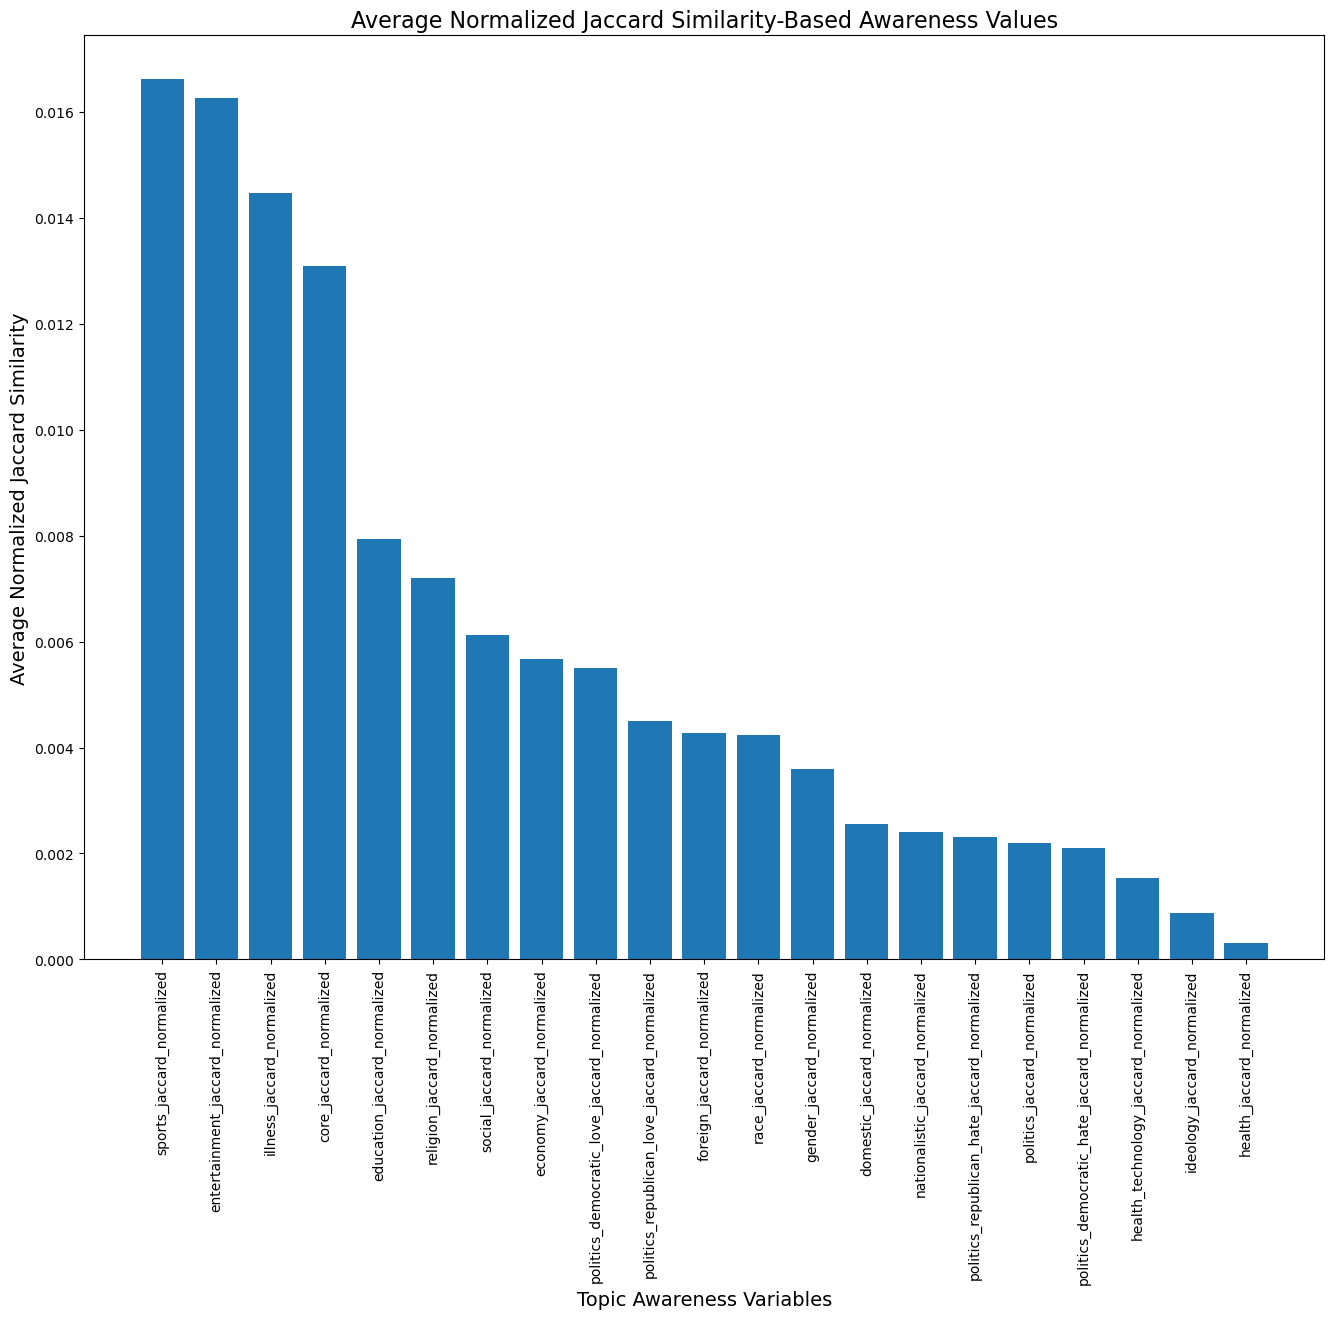

In [10]:
# Average values for all topic awareness variables
topic_awareness_average_values = df_minus_features_columns.mean()

# Extracting normalized Jaccard similarity-based awareness variables
norm_jaccard_sim_vars = [_ for _ in df_minus_features_columns.columns if 
                         "jaccard_normalized" in _]

normalized_jaccard_averages = topic_awareness_average_values[norm_jaccard_sim_vars]

# Plotting bar chart
normalized_jaccard_averages = normalized_jaccard_averages.sort_values(ascending = False)
plt.figure(figsize = (16, 12))
plt.bar(normalized_jaccard_averages.index, normalized_jaccard_averages.values)
plt.xticks(rotation = 90)
plt.xlabel("Topic Awareness Variables", fontsize = 14)
plt.ylabel("Average Normalized Jaccard Similarity", fontsize = 14)
plt.title("Average Normalized Jaccard Similarity-Based Awareness Values", fontsize = 16)
plt.show()

### Summary of Average values for all the topic awareness variables

The bar chart represents Average Normalized Jaccard Similarity-Based Awareness Values for various topic awareness variables. The variables are ranked from highest to lowest average normalized Jaccard similarity. Sports-related topics have the highest average similarity value, indicating possibly the most shared awareness or commonality in discussions or data points among the categories shown. This is followed by entertainment, illness, and education, which also have relatively high awareness values. Topics related to politics, healthcare, and technology, among others, have lower average similarity scores, suggesting less commonality or shared awareness within those areas. The category "health" has the lowest average similarity value, which might reflect a more diverse or less commonly shared awareness in this field.

### Aggregated mean awareness value for each county in Ohio State

In [11]:
# Number of unique values in the "county" column
df_train['county'].nunique()

88

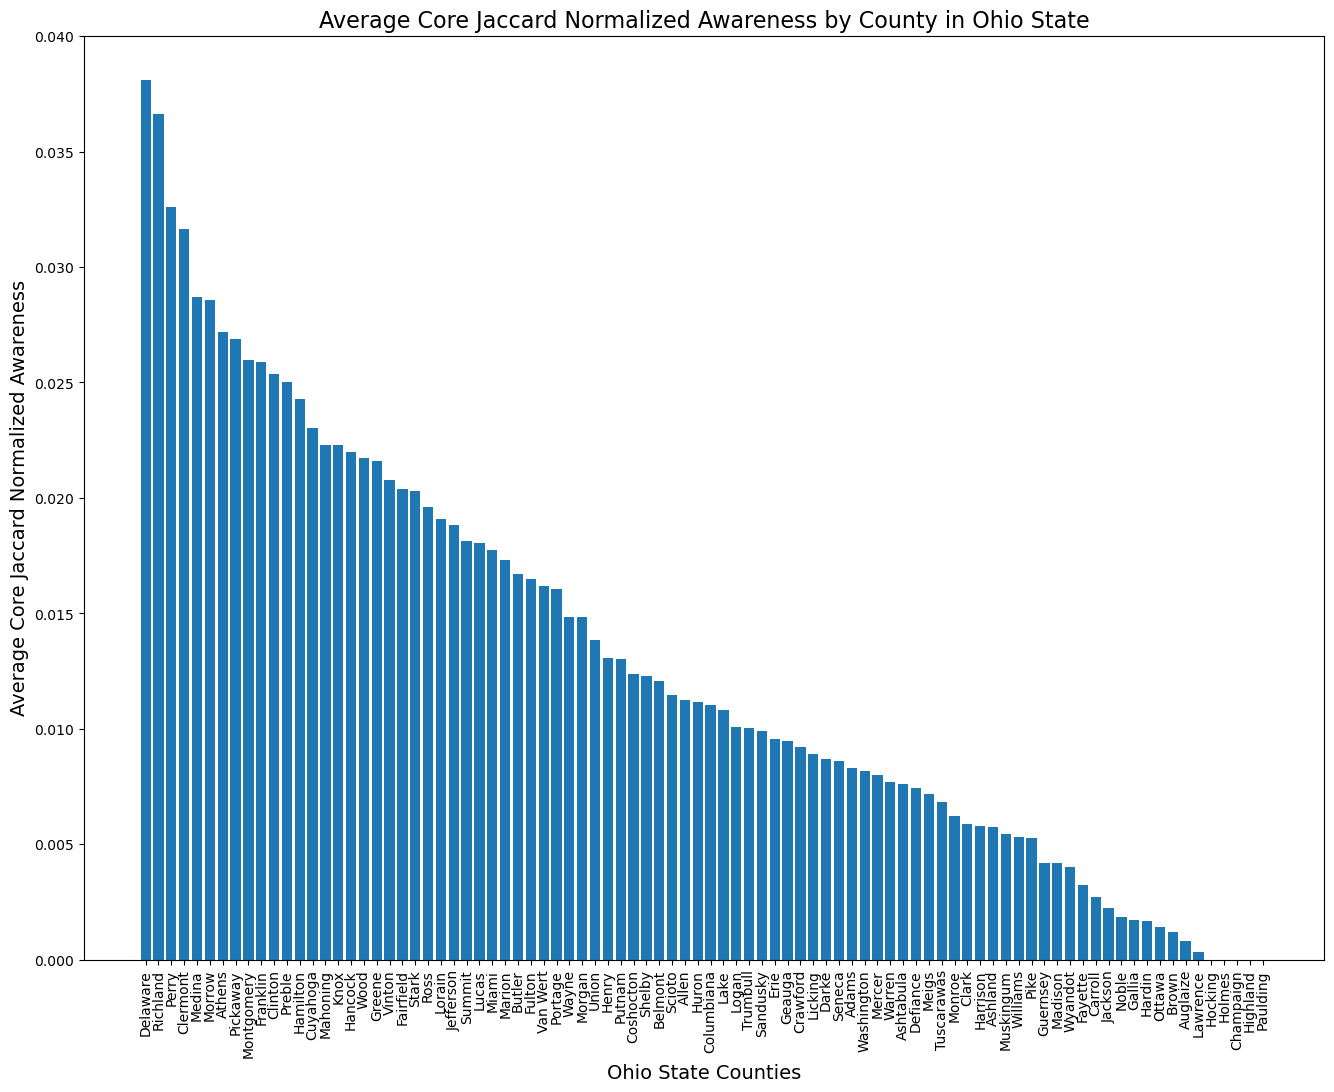

County (highest awareness) is Delaware county.


In [12]:
# Adding back the "county" column
df_core_jaccard_norm_with_county = df_train[["county", "core_jaccard_normalized"]]

# Grouping by "county" and calculating the mean awareness value
county_awareness = df_core_jaccard_norm_with_county.groupby("county")["core_jaccard_normalized"].mean().sort_values(ascending = False)

# Plotting bar chart
plt.figure(figsize = (16, 12))
plt.bar(county_awareness.index, county_awareness.values)

plt.xticks(rotation = 90)

plt.xlabel("Ohio State Counties", fontsize = 14)
plt.ylabel("Average Core Jaccard Normalized Awareness", fontsize = 14)
plt.title("Average Core Jaccard Normalized Awareness by County in Ohio State", 
          fontsize = 16)
plt.show()

# County with highest awareness
highest_awareness_county = county_awareness.idxmax()
print(f"County (highest awareness) is {highest_awareness_county} county.")

### Summary of aggregated mean awareness value

The bar chart illustrates the Average Core Jaccard Normalized Awareness across various counties in Ohio State, ordered from highest to lowest values. The county with the greatest average normalized awareness is Delaware. As the chart progresses to the right, each successive county has a lower average normalized awareness, indicating less shared awareness or engagement. The counties Hocking, Holmes, Champaign, Highland and Paulding have the lowest values, suggesting the least commonality in awareness among the data points. The chart depicts a steep decline initially, which gradually levels off as it extends to the counties with lower awareness levels.

### County-level maps of Ohio showing average Covid-19 cases & deaths per capita

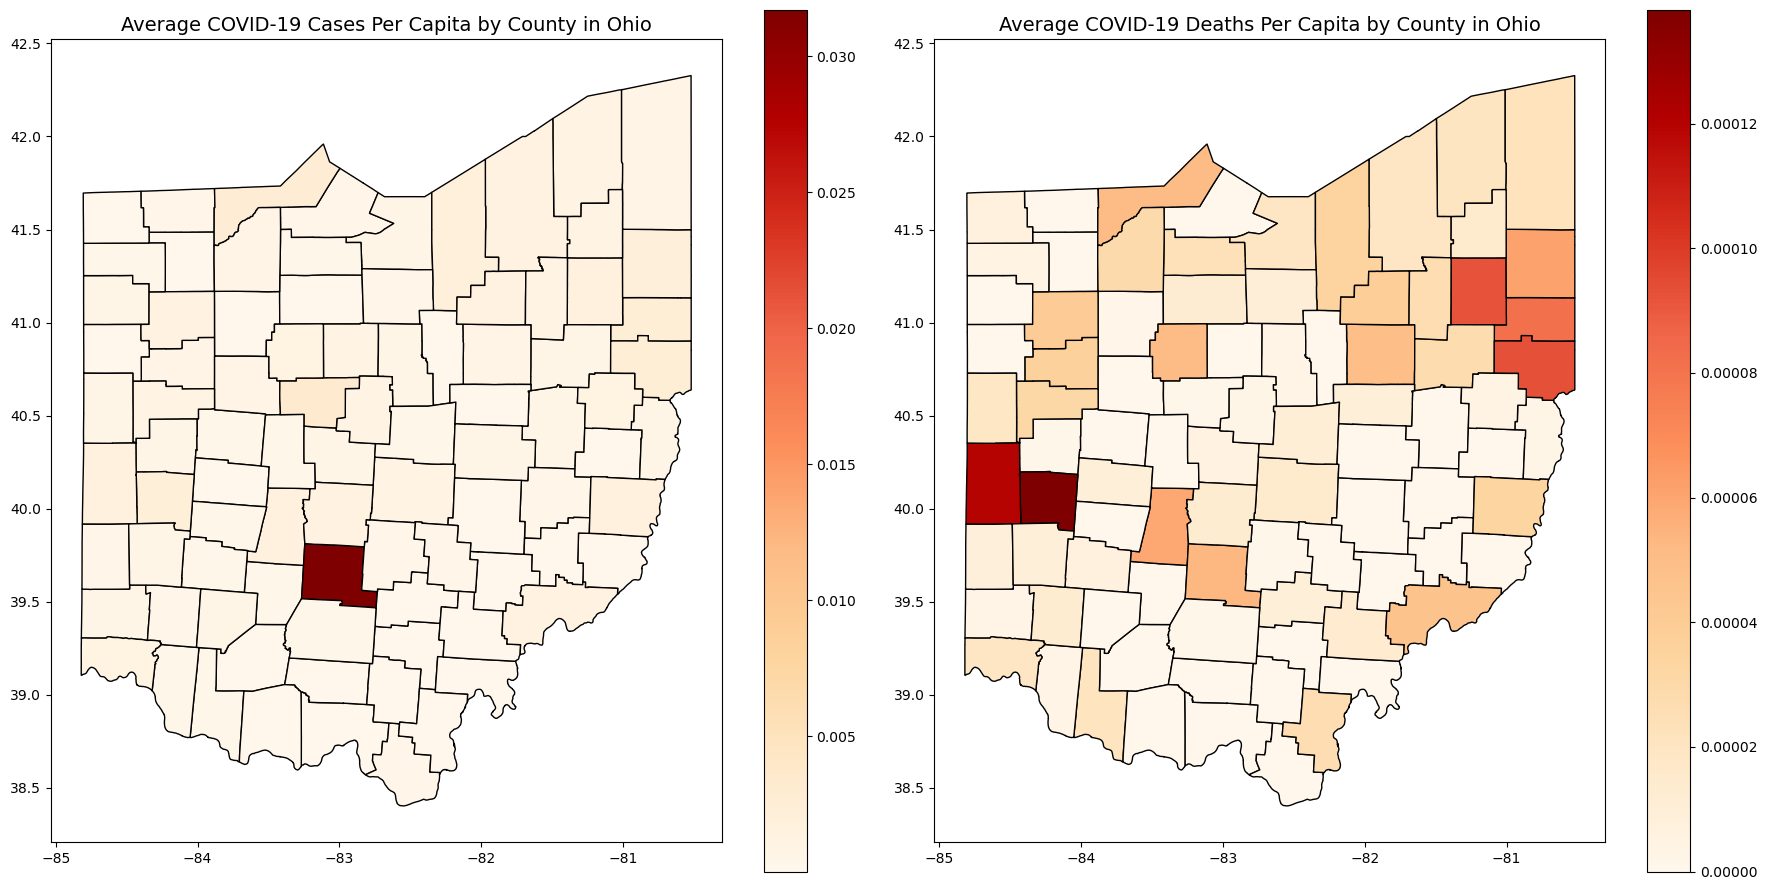

Top-5 counties (Highest Covid-19 cases per capita):
county
Pickaway      0.031700
Marion        0.003405
Lucas         0.002678
Columbiana    0.002627
Mahoning      0.002514
Name: cases_per_capita, dtype: float64

Top-5 counties (Highest Covid-19 deaths per capita):
county
Miami         0.000138
Darke         0.000120
Columbiana    0.000093
Portage       0.000092
Mahoning      0.000082
Name: deaths_per_capita, dtype: float64


In [13]:
# Average cases and deaths per capita
df_train["cases_per_capita"] = df_train["cases"] / df_train["total_pop"]
df_train["deaths_per_capita"] = df_train["deaths"] / df_train["total_pop"]
avg_data = df_train.groupby("county").mean(numeric_only = True)[["cases_per_capita", "deaths_per_capita"]]

# Prepare GeoDataFrame
a = gpd.read_file("/Users/eugeneayonga/Desktop/GOVTUNIT_Ohio_State_Shape/Shape/GU_CountyOrEquivalent.shp")
ohio_counties = a

# Merging data
ohio_data = ohio_counties.merge(avg_data, left_on = "county_nam", right_index = True)

# Creating maps
fig, ax = plt.subplots(1, 2, figsize = (18, 9))

ohio_data.plot(column = "cases_per_capita", ax = ax[0], legend = True,
               cmap = "OrRd", edgecolor = "black")
ax[0].set_title("Average COVID-19 Cases Per Capita by County in Ohio", fontsize = 14)

ohio_data.plot(column = "deaths_per_capita", ax = ax[1], legend = True,
               cmap = "OrRd", edgecolor = "black")
ax[1].set_title("Average COVID-19 Deaths Per Capita by County in Ohio", fontsize = 14)

# Plotting
plt.tight_layout()
plt.show()

# Identifying top-5 counties
top_cases = avg_data["cases_per_capita"].nlargest(5)
top_deaths = avg_data["deaths_per_capita"].nlargest(5)

print("Top-5 counties (Highest Covid-19 cases per capita):")
print(top_cases)

print("\nTop-5 counties (Highest Covid-19 deaths per capita):")
print(top_deaths)

### Summary of county-level maps of Ohio showing average Covid-19 cases & deaths per capita

The twin maps display the average COVID-19 cases and deaths per capita by county in Ohio State. The color gradation from light to dark indicates the intensity of cases or deaths per capita, with darker shades representing higher averages. The map on the left highlights one county with a particularly high average of COVID-19 cases per capita, shown in a striking dark red color (Pickaway county). In contrast, the map on the right, which shows deaths per capita, depicts a different pattern, with a few counties in darker shades indicating higher death rates per capita and one county specifically standing out with the darkest shade (Miami county). The maps together suggest geographic disparities in the impact of COVID-19 across the state, with certain areas being more affected than others either in terms of reported cases or deaths

### Time Series average normalized Jaccard awareness scores for every day (overlapping)

In [14]:
# Normalized Jaccard similarity-based awareness variables
list(df_minus_features_columns)

['core_jaccard',
 'core_cosine',
 'core_intersection',
 'social_jaccard',
 'politics_jaccard',
 'politics_democratic_love_jaccard',
 'nationalistic_jaccard',
 'politics_republican_hate_jaccard',
 'entertainment_jaccard',
 'sports_jaccard',
 'race_jaccard',
 'economy_jaccard',
 'foreign_jaccard',
 'religion_jaccard',
 'health_jaccard',
 'politics_republican_love_jaccard',
 'health_technology_jaccard',
 'politics_democratic_hate_jaccard',
 'domestic_jaccard',
 'illness_jaccard',
 'ideology_jaccard',
 'education_jaccard',
 'gender_jaccard',
 'social_cosine',
 'politics_cosine',
 'politics_democratic_love_cosine',
 'nationalistic_cosine',
 'politics_republican_hate_cosine',
 'entertainment_cosine',
 'sports_cosine',
 'race_cosine',
 'economy_cosine',
 'foreign_cosine',
 'religion_cosine',
 'health_cosine',
 'politics_republican_love_cosine',
 'health_technology_cosine',
 'politics_democratic_hate_cosine',
 'domestic_cosine',
 'illness_cosine',
 'ideology_cosine',
 'education_cosine',
 'gen

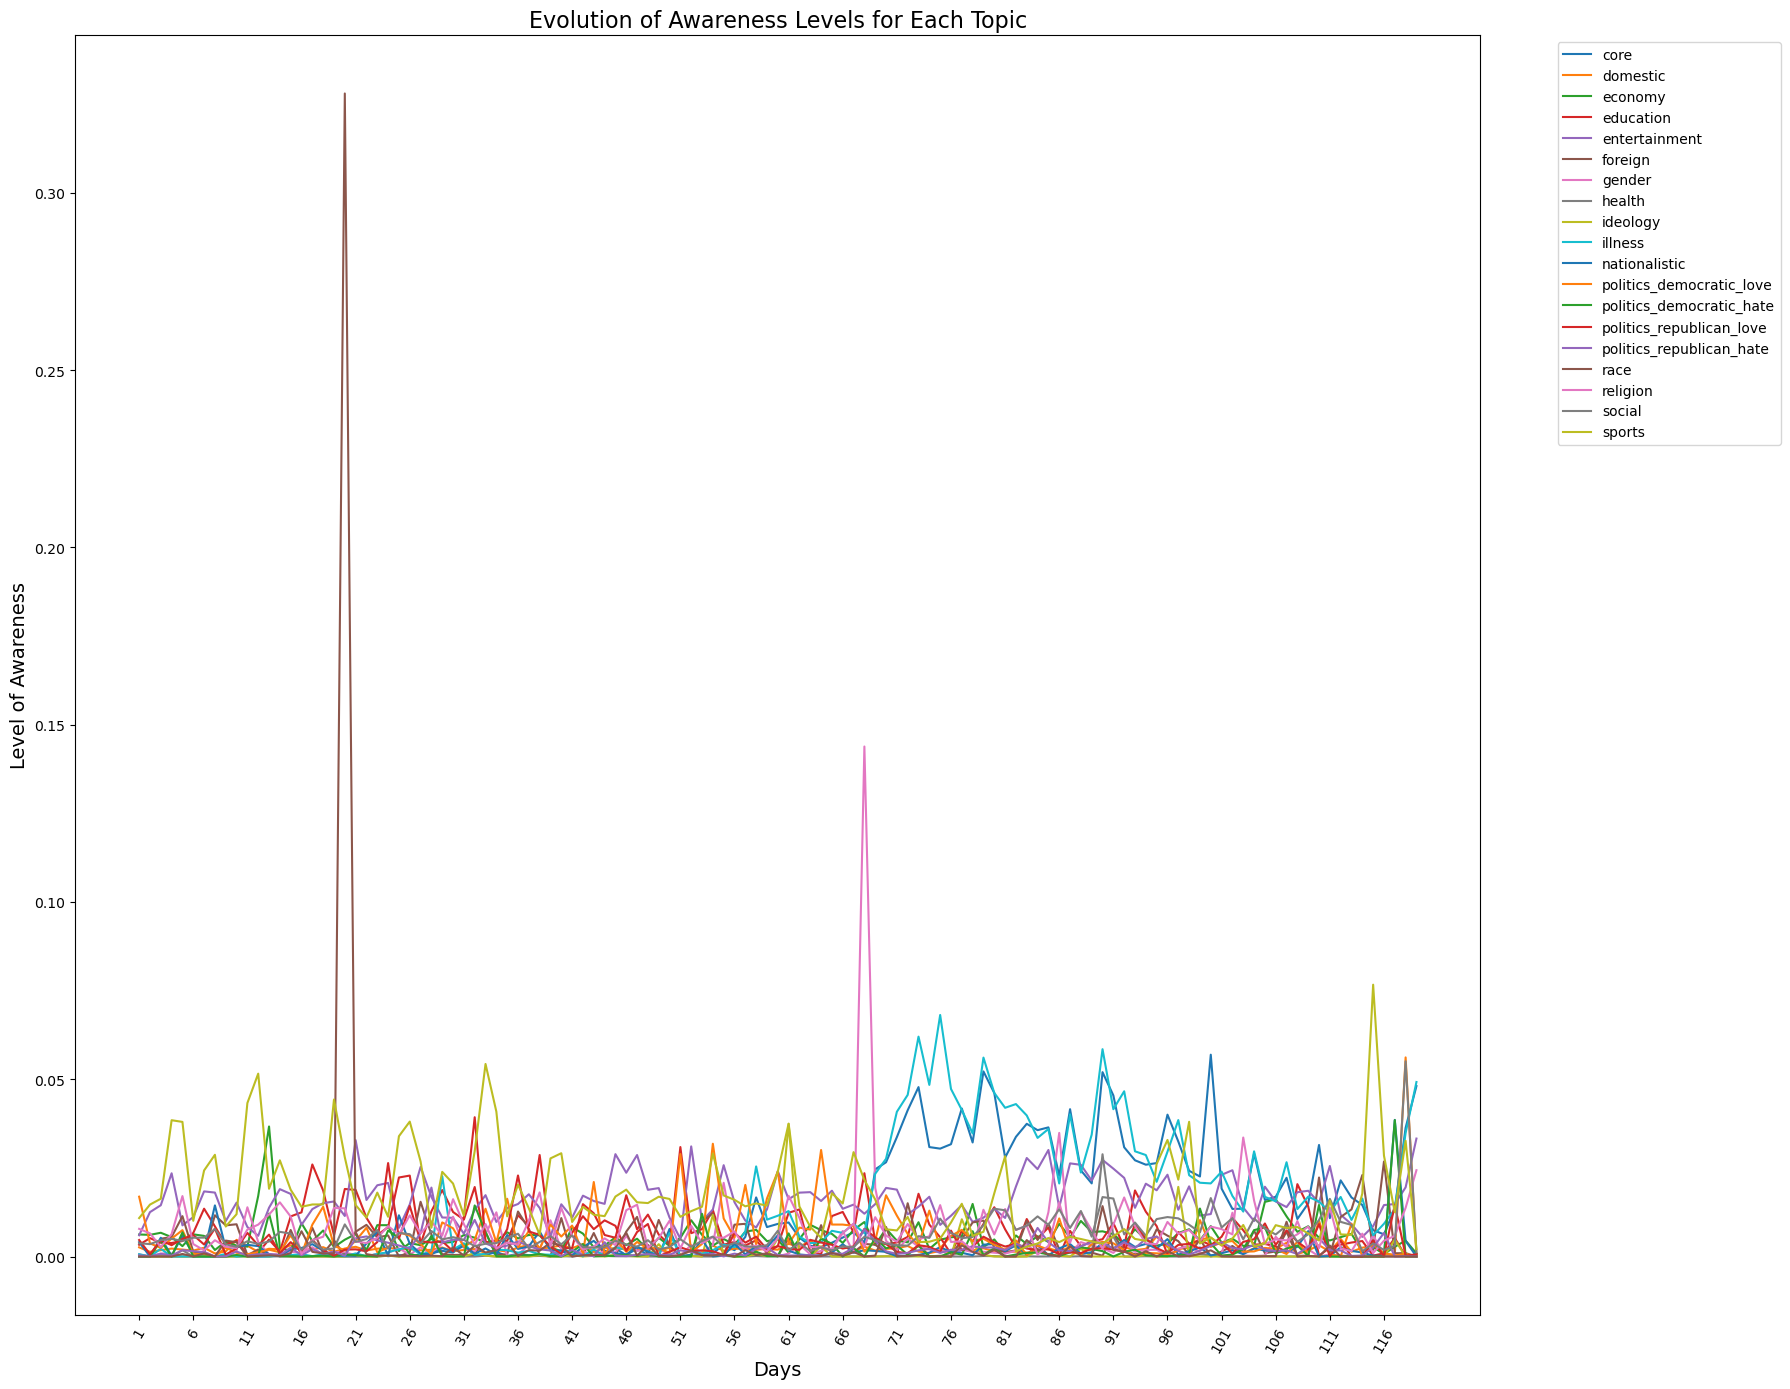

In [15]:
# List of topics
topics = [
    'core', 'domestic', 'economy', 'education', 'entertainment',
    'foreign', 'gender', 'health', 'ideology', 'illness',
    'nationalistic', 'politics_democratic_love', 'politics_democratic_hate',
    'politics_republican_love', 'politics_republican_hate', 'race', 
    'religion', 'social', 'sports'
]

# Empty dictionary to store awareness scores
awareness_scores = {}

# Iterating over each topic, calculating the mean awareness score
df_train['date_index_converted'] = df_train['date_index_converted'].str.replace('day_', '').astype(int)

for topic in topics:
    column_name = f"{topic}_jaccard_normalized"
    awareness_scores[topic] = df_train.groupby('date_index_converted')[column_name].mean()

# Line chart
plt.figure(figsize = (18, 14))
for topic, scores in awareness_scores.items():
    plt.plot(scores.index, scores.values, label = topic)

# Using fewer x-axis labels
days = scores.index
plt.xticks(days[::5])  # Displaying every 7th label

# Rotating x-axis labels and use fewer labels
plt.xticks(rotation = 60)

# Plotting
plt.xlabel('Days', fontsize = 14)
plt.ylabel('Level of Awareness', fontsize = 14)
plt.title('Evolution of Awareness Levels for Each Topic', fontsize = 16)
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.tight_layout()
plt.show()

### Summary of Time Series average normalized Jaccard awareness scores for every day (overlapping)

The graph represents a time series analysis of discussion intensity on various COVID-19-related topics, as measured by social media engagement in Ohio. Each line represents a topic, with noticeable fluctuations over time. Two spikes dominate the visualization: one in the "core" topic early in the timeline and a more pronounced one in "health" later on. The remaining topics exhibit lower and more stable levels of discussion. This suggests that certain events or developments might have triggered these peaks in conversation, possibly correlating with public health announcements or significant pandemic-related incidents. The broad range of topics indicates a diverse public discourse surrounding the pandemic.

# Part II: Model Creation and Prediction

### Evaluation Metric: R2-Value of best model

In [16]:
# STEP 1
# List of columns to remove
features_columns = [
    'county', 'cases', 'deaths', 'date_index_converted', 'county_data_length',
    'total_pop', 'percent_25_34', 'percent_highschool', 'labor_force_rate', 'unemployment_rate',
    'median_housing_cost', 'median_household_earnings', 'median_worker_earnings', 'percent_insured',
    'percent_married', 'poverty_rate', 'median_property_value', 'percent_white'
]

# Dropping the columns
df_minus_features_columns = df_train.drop(columns = features_columns)
df_minus_features_columns.head()

,core_jaccard,core_cosine,core_intersection,social_jaccard,politics_jaccard,politics_democratic_love_jaccard,nationalistic_jaccard,politics_republican_hate_jaccard,entertainment_jaccard,sports_jaccard,race_jaccard,economy_jaccard,foreign_jaccard,religion_jaccard,health_jaccard,politics_republican_love_jaccard,health_technology_jaccard,politics_democratic_hate_jaccard,domestic_jaccard,illness_jaccard,ideology_jaccard,education_jaccard,gender_jaccard,social_cosine,politics_cosine,politics_democratic_love_cosine,nationalistic_cosine,politics_republican_hate_cosine,entertainment_cosine,sports_cosine,race_cosine,economy_cosine,foreign_cosine,religion_cosine,health_cosine,politics_republican_love_cosine,health_technology_cosine,politics_democratic_hate_cosine,domestic_cosine,illness_cosine,ideology_cosine,education_cosine,gender_cosine,social_intersection,politics_intersection,politics_democratic_love_intersection,nationalistic_intersection,politics_republican_hate_intersection,entertainment_intersection,sports_intersection,race_intersection,economy_intersection,foreign_intersection,religion_intersection,health_intersection,politics_republican_love_intersection,health_technology_intersection,politics_democratic_hate_intersection,domestic_intersection,illness_intersection,ideology_intersection,education_intersection,gender_intersection,core_jaccard_normalized,core_cosine_normalized,core_intersection_normalized,ideology_jaccard_normalized,race_jaccard_normalized,economy_jaccard_normalized,sports_jaccard_normalized,foreign_jaccard_normalized,domestic_jaccard_normalized,nationalistic_jaccard_normalized,politics_democratic_love_jaccard_normalized,health_technology_jaccard_normalized,education_jaccard_normalized,gender_jaccard_normalized,religion_jaccard_normalized,social_jaccard_normalized,politics_republican_love_jaccard_normalized,politics_jaccard_normalized,entertainment_jaccard_normalized,politics_republican_hate_jaccard_normalized,politics_democratic_hate_jaccard_normalized,health_jaccard_normalized,illness_jaccard_normalized,ideology_cosine_normalized,race_cosine_normalized,economy_cosine_normalized,sports_cosine_normalized,foreign_cosine_normalized,domestic_cosine_normalized,nationalistic_cosine_normalized,politics_democratic_love_cosine_normalized,health_technology_cosine_normalized,education_cosine_normalized,gender_cosine_normalized,religion_cosine_normalized,social_cosine_normalized,politics_republican_love_cosine_normalized,politics_cosine_normalized,entertainment_cosine_normalized,politics_republican_hate_cosine_normalized,politics_democratic_hate_cosine_normalized,health_cosine_normalized,illness_cosine_normalized,ideology_intersection_normalized,race_intersection_normalized,economy_intersection_normalized,sports_intersection_normalized,foreign_intersection_normalized,domestic_intersection_normalized,nationalistic_intersection_normalized,politics_democratic_love_intersection_normalized,health_technology_intersection_normalized,education_intersection_normalized,gender_intersection_normalized,religion_intersection_normalized,social_intersection_normalized,politics_republican_love_intersection_normalized,politics_intersection_normalized,entertainment_intersection_normalized,politics_republican_hate_intersection_normalized,politics_democratic_hate_intersection_normalized,health_intersection_normalized,illness_intersection_normalized,cases_per_capita,deaths_per_capita
0,0.000000,0.00000,0.000000,0.000011,0.000151,0.000053,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000125,0.0,0.0,0.000047,0.00000,0.0,0.000000,0.0,0.000054,0.000902,0.000154,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000356,0.0,0.0,0.000522,0.000000,0.0,0.000000,0.0,0.002755,0.013774,0.002755,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0000,0.0,0.002755,0.0,0.0,0.011019,0.000000,0.0,0.0000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.005499,0.0,0.021079,0.0,0.000000,0.0,0.000000,0.002632,0.010518,0.018491,0.000000,0.0,

In [17]:
# STEP 2
# DIMENSIONALITY REDUCTION

# Setting the number of components
n_components = 4

# Initializing and fitting PCA
spectral_emb_red_dim = SpectralEmbedding(n_components = n_components, random_state = 265)
df_spectral_emb_red_dim = spectral_emb_red_dim.fit_transform(df_minus_features_columns.to_numpy())

# Converting the result to a DataFrame
df_spectral_emb_red_dim = pd.DataFrame(df_spectral_emb_red_dim, 
                                        columns=[f'Spectral_Embedding_{i+1}' 
                                                 for i in range(n_components)])
df_spectral_emb_red_dim.head()

,Spectral_Embedding_1,Spectral_Embedding_2,Spectral_Embedding_3,Spectral_Embedding_4
0,-0.000776,-0.000542,-0.000156,-0.000510
1,0.000124,0.000328,0.002942,0.002773
2,0.001553,-0.000624,-0.000189,-0.000716
3,0.000333,0.000355,0.002776,0.003154
4,0.000109,0.000587,0.002491,0.002318


In [18]:
# STEP 3
# List of feature columns
feature_columns = [
    'county', 'cases', 'deaths', 'date_index_converted', 'county_data_length',
    'total_pop', 'percent_25_34', 'percent_highschool', 'labor_force_rate', 'unemployment_rate',
    'median_housing_cost', 'median_household_earnings', 'median_worker_earnings', 'percent_insured',
    'percent_married', 'poverty_rate', 'median_property_value', 'percent_white'
]

# Creating a new DataFrame with only the columns in topics
df_feature_columns = df_train[feature_columns]
df_feature_columns.head()

,county,cases,deaths,date_index_converted,county_data_length,total_pop,percent_25_34,percent_highschool,labor_force_rate,unemployment_rate,median_housing_cost,median_household_earnings,median_worker_earnings,percent_insured,percent_married,poverty_rate,median_property_value,percent_white
0,Richland,0,0,10,363,122312,12.1,86.9,55.5,7.5,675,41877,23210,90.5,48.3,15.6,103700,0.868085
1,Lawrence,119,0,105,256,61827,11.8,85.9,53.5,6.5,655,42874,23510,92.2,49.3,18.6,101500,0.954027
2,Wayne,49,0,90,769,115371,11.6,85.8,64.0,4.0,762,50383,26658,87.2,55.1,13.0,140100,0.950541
3,Fayette,7,0,85,36,28769,11.7,87.1,59.3,6.3,732,40503,25858,91.3,51.8,17.7,108900,0.940054
4,Trumbull,0,0,7,554,206373,11.1,89.0,56.4,5.9,661,43073,25800,91.7,49.1,17.2,101600,0.885724


In [19]:
# STEP 4
df_combined_train = pd.concat([df_feature_columns, df_spectral_emb_red_dim], axis = 1)
df_combined_train.head()

,county,cases,deaths,date_index_converted,county_data_length,total_pop,percent_25_34,percent_highschool,labor_force_rate,unemployment_rate,median_housing_cost,median_household_earnings,median_worker_earnings,percent_insured,percent_married,poverty_rate,median_property_value,percent_white,Spectral_Embedding_1,Spectral_Embedding_2,Spectral_Embedding_3,Spectral_Embedding_4
0,Richland,0,0,10,363,122312,12.1,86.9,55.5,7.5,675,41877,23210,90.5,48.3,15.6,103700,0.868085,-0.000776,-0.000542,-0.000156,-0.000510
1,Lawrence,119,0,105,256,61827,11.8,85.9,53.5,6.5,655,42874,23510,92.2,49.3,18.6,101500,0.954027,0.000124,0.000328,0.002942,0.002773
2,Wayne,49,0,90,769,115371,11.6,85.8,64.0,4.0,762,50383,26658,87.2,55.1,13.0,140100,0.950541,0.001553,-0.000624,-0.000189,-0.000716
3,Fayette,7,0,85,36,28769,11.7,87.1,59.3,6.3,732,40503,25858,91.3,51.8,17.7,108900,0.940054,0.000333,0.000355,0.002776,0.003154
4,Trumbull,0,0,7,554,206373,11.1,89.0,56.4,5.9,661,43073,25800,91.7,49.1,17.2,101600,0.885724,0.000109,0.000587,0.002491,0.002318


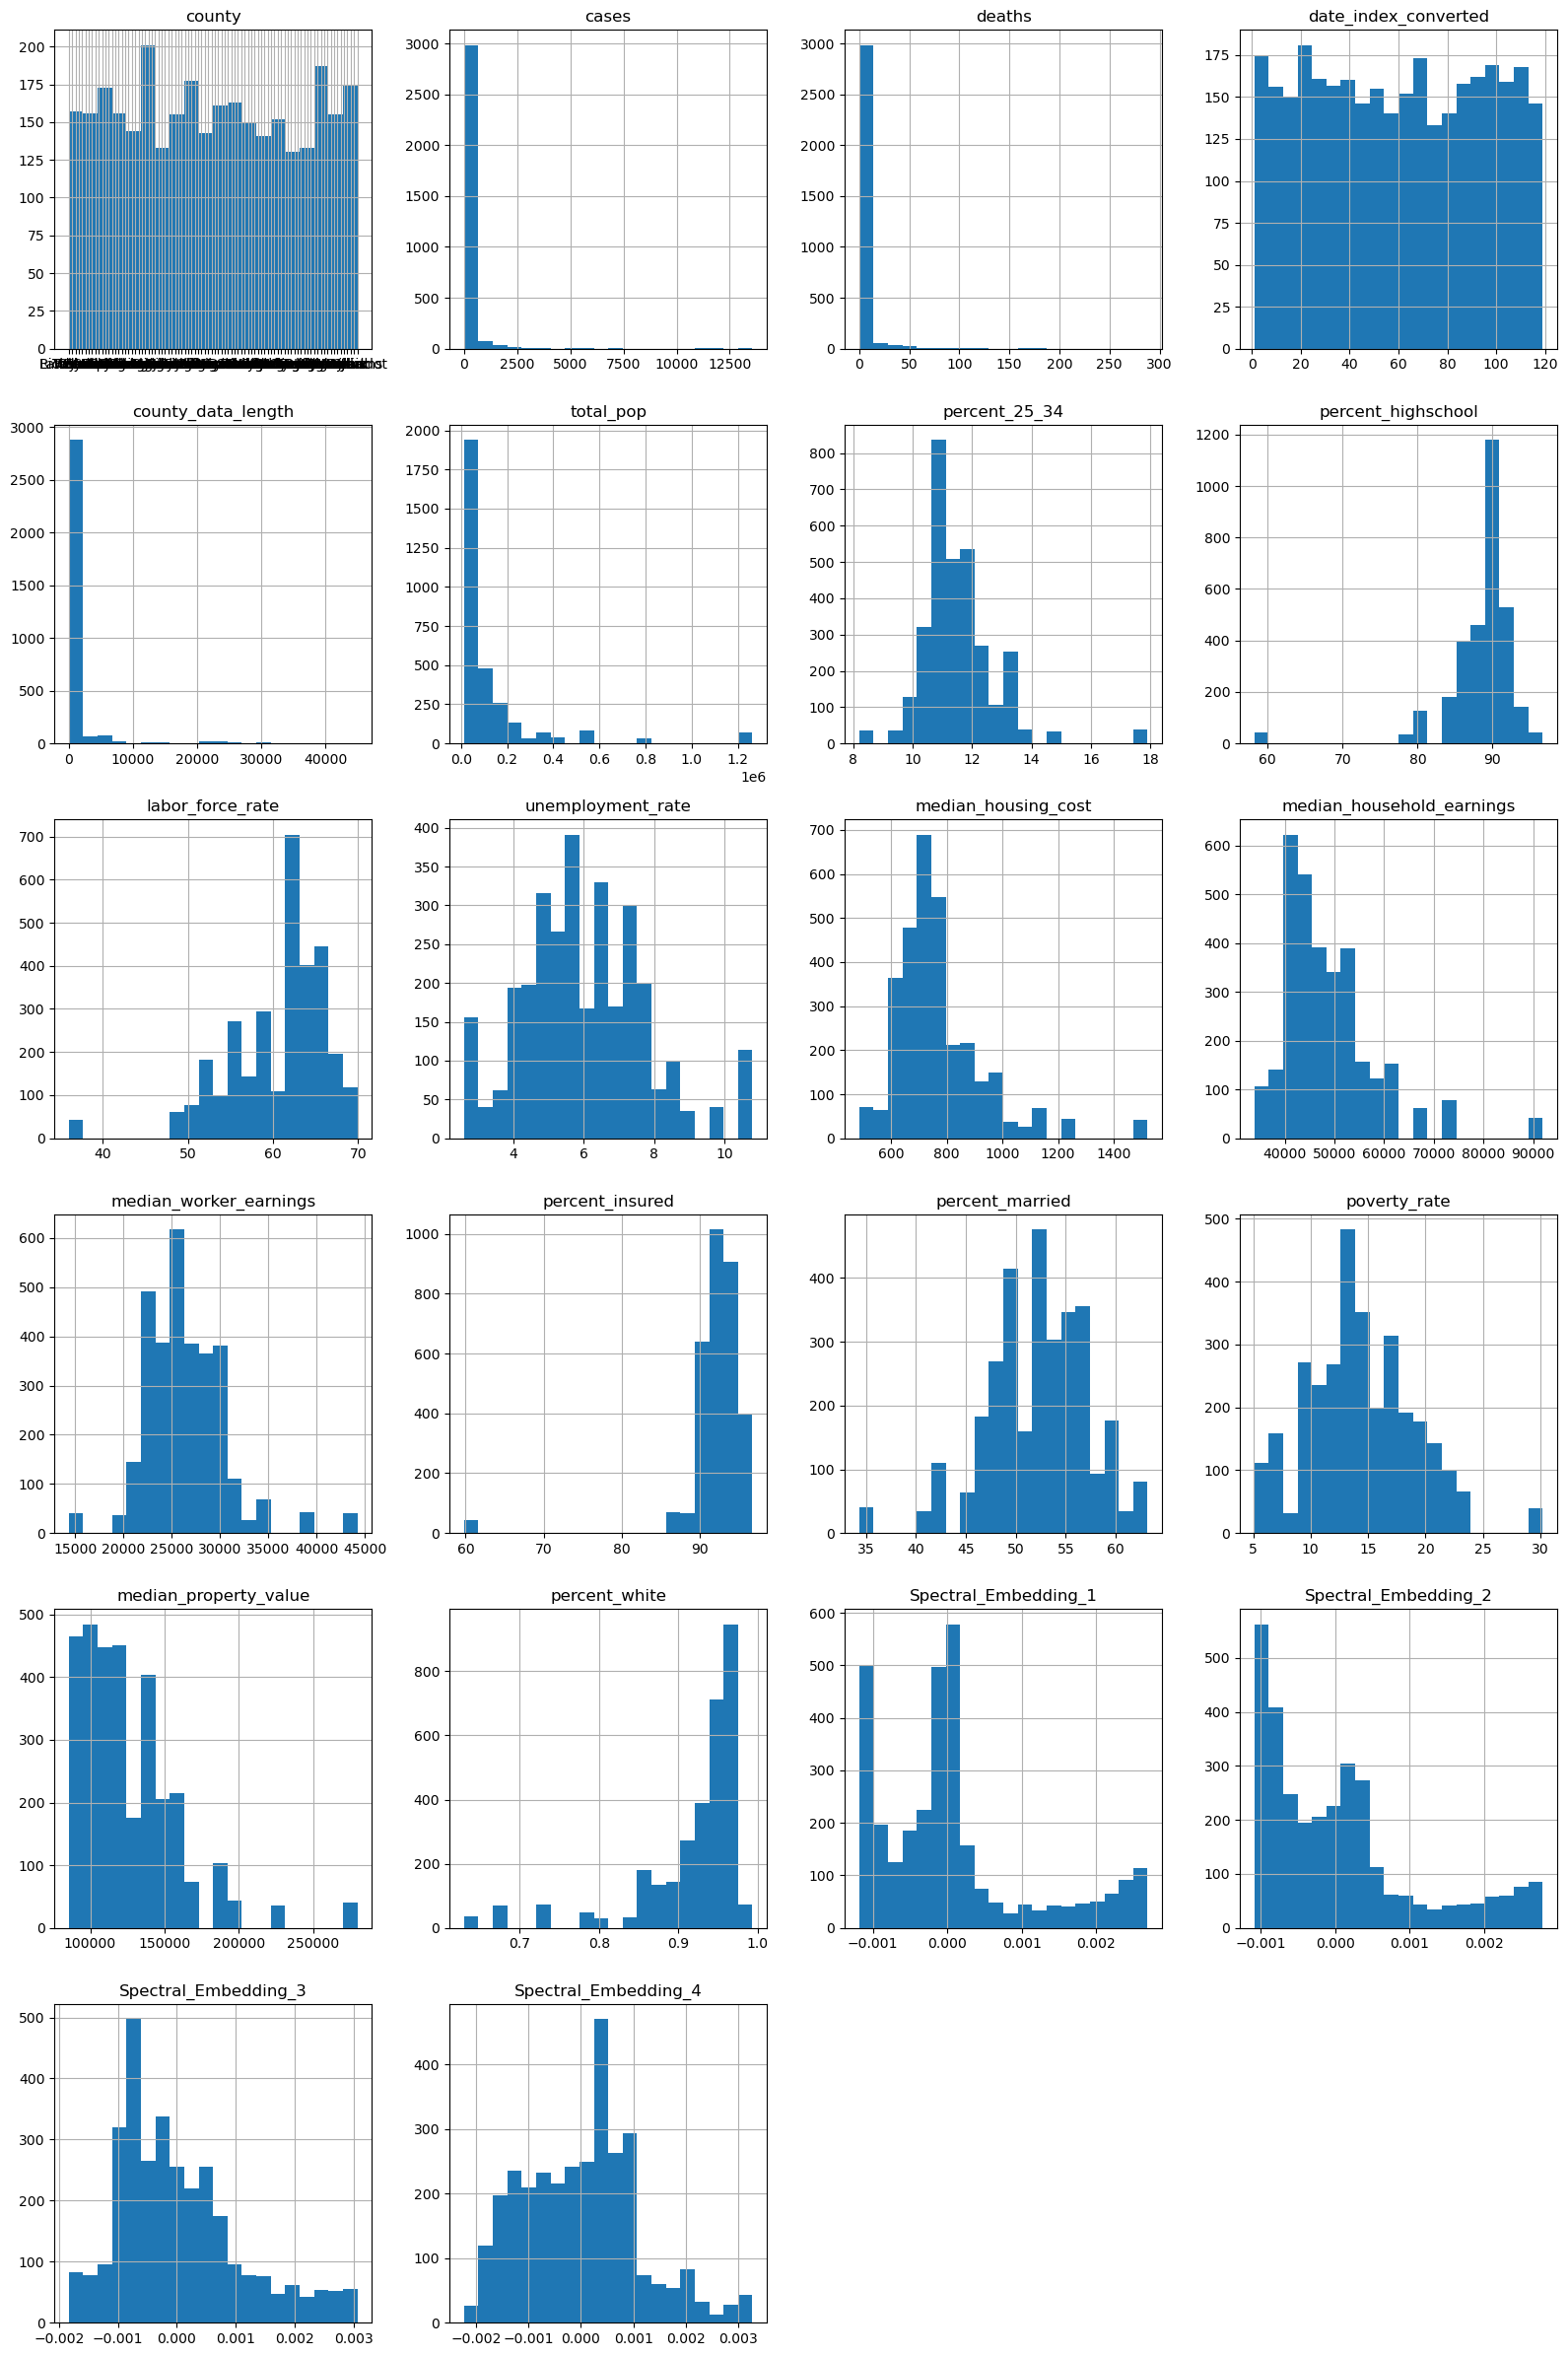

In [20]:
# STEP 5 --> Checking Distributions

# Number of variables in the DataFrame
n_vars = len(df_combined_train.columns)

# Calculating the number of rows and columns for the subplot grid
n_rows = int(np.ceil(n_vars / 4))
n_cols = 4

# Creating a figure and axes for the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize = (16, n_rows * 4))

# Plotting histograms for each variable
for i, col in enumerate(df_combined_train.columns):
    ax = axes[i // n_cols, i % n_cols]
    df_combined_train[col].hist(ax = ax, bins = 20)
    ax.set_title(col)

# Hiding any empty subplots
for i in range(n_vars, n_rows * n_cols):
    axes[i // n_cols, i % n_cols].axis('off')

# Displaying
plt.tight_layout()
plt.show() 

In [21]:
# STEP 6
# Dropping 'county' and 'date_index_converted' columns
df_combined_train = df_combined_train.drop(columns = ['county', 'date_index_converted'])
df_combined_train.head()

,cases,deaths,county_data_length,total_pop,percent_25_34,percent_highschool,labor_force_rate,unemployment_rate,median_housing_cost,median_household_earnings,median_worker_earnings,percent_insured,percent_married,poverty_rate,median_property_value,percent_white,Spectral_Embedding_1,Spectral_Embedding_2,Spectral_Embedding_3,Spectral_Embedding_4
0,0,0,363,122312,12.1,86.9,55.5,7.5,675,41877,23210,90.5,48.3,15.6,103700,0.868085,-0.000776,-0.000542,-0.000156,-0.000510
1,119,0,256,61827,11.8,85.9,53.5,6.5,655,42874,23510,92.2,49.3,18.6,101500,0.954027,0.000124,0.000328,0.002942,0.002773
2,49,0,769,115371,11.6,85.8,64.0,4.0,762,50383,26658,87.2,55.1,13.0,140100,0.950541,0.001553,-0.000624,-0.000189,-0.000716
3,7,0,36,28769,11.7,87.1,59.3,6.3,732,40503,25858,91.3,51.8,17.7,108900,0.940054,0.000333,0.000355,0.002776,0.003154
4,0,0,554,206373,11.1,89.0,56.4,5.9,661,43073,25800,91.7,49.1,17.2,101600,0.885724,0.000109,0.000587,0.002491,0.002318


In [22]:
# STEP 7 --> The Model

# Splitting the data into features and target
X = df_combined_train.drop(columns = ['cases'])
y = df_combined_train['cases']

# X normalization
scaler_X = MinMaxScaler()
X_normalized = scaler_X.fit_transform(X)

# Y normalization
scaler_y = MinMaxScaler()
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Splitting the normalized data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, 
                                                    y_normalized, test_size = 0.2, 
                                                    random_state = 265)

# Defining hyperparameters
learning_rate = 0.19
n_estimators = 38000

# Training an XGBoost regression model with specified hyperparameters
predictive_model = XGBRegressor(random_state = 265, 
                                           learning_rate = learning_rate, 
                                           n_estimators = n_estimators)

predictive_model.fit(X_train, y_train)

# Making predictions and evaluating the model
y_pred = predictive_model.predict(X_test)

# Inverse transforming the predictions to get the original scale
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Computing metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
median_ae = median_absolute_error(y_test_original, y_pred_original)
explained_variance = explained_variance_score(y_test_original, y_pred_original)

# Mean Squared Log Error requires non-negative values
msle = mean_squared_log_error(np.maximum(y_test_original, 0), np.maximum(y_pred_original, 0))

# Adjusted R-squared
n = len(y_test_original)  # number of samples
p = X.shape[1]  # number of predictors
adj_r2 = 1 - ((1 - r2_score(y_test_original, y_pred_original)) * (n - 1) / (n - p - 1))

# Printing the metrics
print(f"\nMean Absolute Error (MAE): {round(mae, 4)}")
print(f"\nMean Squared Error (MSE): {round(mse, 4)}")
print(f"\nRoot Mean Squared Error (RMSE): {round(rmse, 4)}")
print(f"\nMedian Absolute Error: {round(median_ae, 4)}")
print(f"\nExplained Variance Score: {round(explained_variance, 4)}")
print(f"\nMean Squared Log Error (MSLE): {round(msle, 4)}")
print(f"\nAdjusted R2-Value: {round(adj_r2, 4)}")


Mean Absolute Error (MAE): 41.1487

Mean Squared Error (MSE): 24281.5114

Root Mean Squared Error (RMSE): 155.8253

Median Absolute Error: 9.2066

Explained Variance Score: 0.9616

Mean Squared Log Error (MSLE): 3.965

Adjusted R2-Value: 0.9604


# Part III: Model Evaluation

In [23]:
# LOADING THE TEST DATA
df_test = pd.read_csv("/Users/eugeneayonga/Desktop/test_data.csv")
df_test.head()

,index,county,deaths,date_index_converted,county_data_length,core_jaccard,core_cosine,core_intersection,social_jaccard,politics_jaccard,politics_democratic_love_jaccard,nationalistic_jaccard,politics_republican_hate_jaccard,entertainment_jaccard,sports_jaccard,race_jaccard,economy_jaccard,foreign_jaccard,religion_jaccard,health_jaccard,politics_republican_love_jaccard,health_technology_jaccard,politics_democratic_hate_jaccard,domestic_jaccard,illness_jaccard,ideology_jaccard,education_jaccard,gender_jaccard,social_cosine,politics_cosine,politics_democratic_love_cosine,nationalistic_cosine,politics_republican_hate_cosine,entertainment_cosine,sports_cosine,race_cosine,economy_cosine,foreign_cosine,religion_cosine,health_cosine,politics_republican_love_cosine,health_technology_cosine,politics_democratic_hate_cosine,domestic_cosine,illness_cosine,ideology_cosine,education_cosine,gender_cosine,social_intersection,politics_intersection,politics_democratic_love_intersection,nationalistic_intersection,politics_republican_hate_intersection,entertainment_intersection,sports_intersection,race_intersection,economy_intersection,foreign_intersection,religion_intersection,health_intersection,politics_republican_love_intersection,health_technology_intersection,politics_democratic_hate_intersection,domestic_intersection,illness_intersection,ideology_intersection,education_intersection,gender_intersection,core_jaccard_normalized,core_cosine_normalized,core_intersection_normalized,ideology_jaccard_normalized,race_jaccard_normalized,economy_jaccard_normalized,sports_jaccard_normalized,foreign_jaccard_normalized,domestic_jaccard_normalized,nationalistic_jaccard_normalized,politics_democratic_love_jaccard_normalized,health_technology_jaccard_normalized,education_jaccard_normalized,gender_jaccard_normalized,religion_jaccard_normalized,social_jaccard_normalized,politics_republican_love_jaccard_normalized,politics_jaccard_normalized,entertainment_jaccard_normalized,politics_republican_hate_jaccard_normalized,politics_democratic_hate_jaccard_normalized,health_jaccard_normalized,illness_jaccard_normalized,ideology_cosine_normalized,race_cosine_normalized,economy_cosine_normalized,sports_cosine_normalized,foreign_cosine_normalized,domestic_cosine_normalized,nationalistic_cosine_normalized,politics_democratic_love_cosine_normalized,health_technology_cosine_normalized,education_cosine_normalized,gender_cosine_normalized,religion_cosine_normalized,social_cosine_normalized,politics_republican_love_cosine_normalized,politics_cosine_normalized,entertainment_cosine_normalized,politics_republican_hate_cosine_normalized,politics_democratic_hate_cosine_normalized,health_cosine_normalized,illness_cosine_normalized,ideology_intersection_normalized,race_intersection_normalized,economy_intersection_normalized,sports_intersection_normalized,foreign_intersection_normalized,domestic_intersection_normalized,nationalistic_intersection_normalized,politics_democratic_love_intersection_normalized,health_technology_intersection_normalized,education_intersection_normalized,gender_intersection_normalized,religion_intersection_normalized,social_intersection_normalized,politics_republican_love_intersection_normalized,politics_intersection_normalized,entertainment_intersection_normalized,politics_republican_hate_intersection_normalized,politics_democratic_hate_intersection_normalized,health_intersection_normalized,illness_intersection_normalized,total_pop,percent_25_34,percent_highschool,labor_force_rate,unemployment_rate,median_housing_cost,median_household_earnings,median_worker_earnings,percent_insured,percent_married,poverty_rate,median_property_value,percent_white
0,0,Carroll,0,day_22,40,0.000000,0.000000,0.000000,0.000106,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.001153,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000

In [24]:
# Checking the shape of the test data
df_test.shape

(7331, 144)

In [25]:
# Checking for missing values and filter columns with null values
len(df_test.isnull().sum()[lambda x: x > 0])

0

In [26]:
df_test.describe()

,index,deaths,county_data_length,core_jaccard,core_cosine,core_intersection,social_jaccard,politics_jaccard,politics_democratic_love_jaccard,nationalistic_jaccard,politics_republican_hate_jaccard,entertainment_jaccard,sports_jaccard,race_jaccard,economy_jaccard,foreign_jaccard,religion_jaccard,health_jaccard,politics_republican_love_jaccard,health_technology_jaccard,politics_democratic_hate_jaccard,domestic_jaccard,illness_jaccard,ideology_jaccard,education_jaccard,gender_jaccard,social_cosine,politics_cosine,politics_democratic_love_cosine,nationalistic_cosine,politics_republican_hate_cosine,entertainment_cosine,sports_cosine,race_cosine,economy_cosine,foreign_cosine,religion_cosine,health_cosine,politics_republican_love_cosine,health_technology_cosine,politics_democratic_hate_cosine,domestic_cosine,illness_cosine,ideology_cosine,education_cosine,gender_cosine,social_intersection,politics_intersection,politics_democratic_love_intersection,nationalistic_intersection,politics_republican_hate_intersection,entertainment_intersection,sports_intersection,race_intersection,economy_intersection,foreign_intersection,religion_intersection,health_intersection,politics_republican_love_intersection,health_technology_intersection,politics_democratic_hate_intersection,domestic_intersection,illness_intersection,ideology_intersection,education_intersection,gender_intersection,core_jaccard_normalized,core_cosine_normalized,core_intersection_normalized,ideology_jaccard_normalized,race_jaccard_normalized,economy_jaccard_normalized,sports_jaccard_normalized,foreign_jaccard_normalized,domestic_jaccard_normalized,nationalistic_jaccard_normalized,politics_democratic_love_jaccard_normalized,health_technology_jaccard_normalized,education_jaccard_normalized,gender_jaccard_normalized,religion_jaccard_normalized,social_jaccard_normalized,politics_republican_love_jaccard_normalized,politics_jaccard_normalized,entertainment_jaccard_normalized,politics_republican_hate_jaccard_normalized,politics_democratic_hate_jaccard_normalized,health_jaccard_normalized,illness_jaccard_normalized,ideology_cosine_normalized,race_cosine_normalized,economy_cosine_normalized,sports_cosine_normalized,foreign_cosine_normalized,domestic_cosine_normalized,nationalistic_cosine_normalized,politics_democratic_love_cosine_normalized,health_technology_cosine_normalized,education_cosine_normalized,gender_cosine_normalized,religion_cosine_normalized,social_cosine_normalized,politics_republican_love_cosine_normalized,politics_cosine_normalized,entertainment_cosine_normalized,politics_republican_hate_cosine_normalized,politics_democratic_hate_cosine_normalized,health_cosine_normalized,illness_cosine_normalized,ideology_intersection_normalized,race_intersection_normalized,economy_intersection_normalized,sports_intersection_normalized,foreign_intersection_normalized,domestic_intersection_normalized,nationalistic_intersection_normalized,politics_democratic_love_intersection_normalized,health_technology_intersection_normalized,education_intersection_normalized,gender_intersection_normalized,religion_intersection_normalized,social_intersection_normalized,politics_republican_love_intersection_normalized,politics_intersection_normalized,entertainment_intersection_normalized,politics_republican_hate_intersection_normalized,politics_democratic_hate_intersection_normalized,health_intersection_normalized,illness_intersection_normalized,total_pop,percent_25_34,percent_highschool,labor_force_rate,unemployment_rate,median_housing_cost,median_household_earnings,median_worker_earnings,percent_insured,percent_married,poverty_rate,median_property_value,percent_white
count,7331.000000,7331.000000,7331.00000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.000000,7331.

In [27]:
# PREDICTION ON UNSEEN DATA

# STEP 8
# List of columns to remove
features_columns_test = [
    'index', 'county', 'deaths', 'date_index_converted', 'county_data_length',
    'total_pop', 'percent_25_34', 'percent_highschool', 'labor_force_rate', 'unemployment_rate',
    'median_housing_cost', 'median_household_earnings', 'median_worker_earnings', 'percent_insured',
    'percent_married', 'poverty_rate', 'median_property_value', 'percent_white'
]

# Dropping the columns
df_minus_features_columns_test = df_test.drop(columns = features_columns_test)
df_minus_features_columns_test.head()

,core_jaccard,core_cosine,core_intersection,social_jaccard,politics_jaccard,politics_democratic_love_jaccard,nationalistic_jaccard,politics_republican_hate_jaccard,entertainment_jaccard,sports_jaccard,race_jaccard,economy_jaccard,foreign_jaccard,religion_jaccard,health_jaccard,politics_republican_love_jaccard,health_technology_jaccard,politics_democratic_hate_jaccard,domestic_jaccard,illness_jaccard,ideology_jaccard,education_jaccard,gender_jaccard,social_cosine,politics_cosine,politics_democratic_love_cosine,nationalistic_cosine,politics_republican_hate_cosine,entertainment_cosine,sports_cosine,race_cosine,economy_cosine,foreign_cosine,religion_cosine,health_cosine,politics_republican_love_cosine,health_technology_cosine,politics_democratic_hate_cosine,domestic_cosine,illness_cosine,ideology_cosine,education_cosine,gender_cosine,social_intersection,politics_intersection,politics_democratic_love_intersection,nationalistic_intersection,politics_republican_hate_intersection,entertainment_intersection,sports_intersection,race_intersection,economy_intersection,foreign_intersection,religion_intersection,health_intersection,politics_republican_love_intersection,health_technology_intersection,politics_democratic_hate_intersection,domestic_intersection,illness_intersection,ideology_intersection,education_intersection,gender_intersection,core_jaccard_normalized,core_cosine_normalized,core_intersection_normalized,ideology_jaccard_normalized,race_jaccard_normalized,economy_jaccard_normalized,sports_jaccard_normalized,foreign_jaccard_normalized,domestic_jaccard_normalized,nationalistic_jaccard_normalized,politics_democratic_love_jaccard_normalized,health_technology_jaccard_normalized,education_jaccard_normalized,gender_jaccard_normalized,religion_jaccard_normalized,social_jaccard_normalized,politics_republican_love_jaccard_normalized,politics_jaccard_normalized,entertainment_jaccard_normalized,politics_republican_hate_jaccard_normalized,politics_democratic_hate_jaccard_normalized,health_jaccard_normalized,illness_jaccard_normalized,ideology_cosine_normalized,race_cosine_normalized,economy_cosine_normalized,sports_cosine_normalized,foreign_cosine_normalized,domestic_cosine_normalized,nationalistic_cosine_normalized,politics_democratic_love_cosine_normalized,health_technology_cosine_normalized,education_cosine_normalized,gender_cosine_normalized,religion_cosine_normalized,social_cosine_normalized,politics_republican_love_cosine_normalized,politics_cosine_normalized,entertainment_cosine_normalized,politics_republican_hate_cosine_normalized,politics_democratic_hate_cosine_normalized,health_cosine_normalized,illness_cosine_normalized,ideology_intersection_normalized,race_intersection_normalized,economy_intersection_normalized,sports_intersection_normalized,foreign_intersection_normalized,domestic_intersection_normalized,nationalistic_intersection_normalized,politics_democratic_love_intersection_normalized,health_technology_intersection_normalized,education_intersection_normalized,gender_intersection_normalized,religion_intersection_normalized,social_intersection_normalized,politics_republican_love_intersection_normalized,politics_intersection_normalized,entertainment_intersection_normalized,politics_republican_hate_intersection_normalized,politics_democratic_hate_intersection_normalized,health_intersection_normalized,illness_intersection_normalized
0,0.000000,0.000000,0.000000,0.000106,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.001153,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [28]:
# STEP 9
# DIMENSIONALITY REDUCTION --> Spectral Embedding

# Setting number of components
n_components = 4

# Initializing and fitting Spectral Embedding
spectral_emb_red_dim_test = SpectralEmbedding(n_components = n_components, random_state = 265)
df_spectral_emb_red_dim_test = spectral_emb_red_dim_test.fit_transform(df_minus_features_columns_test.to_numpy())

# Converting result to a DataFrame
df_spectral_emb_red_dim_test = pd.DataFrame(df_spectral_emb_red_dim_test, columns=[f'Spectral_Embedding_{i+1}' for i in range(n_components)])
df_spectral_emb_red_dim_test.head()

,Spectral_Embedding_1,Spectral_Embedding_2,Spectral_Embedding_3,Spectral_Embedding_4
0,-0.000397,-0.000254,-0.000084,0.000039
1,0.001086,-0.000657,-0.000427,-0.000379
2,0.000094,0.000769,-0.000361,0.000113
3,-0.000447,-0.000297,-0.000167,-0.000100
4,-0.000151,-0.000037,0.000247,0.000346


In [29]:
# STEP 10
# List of columns to remove
features_columns_test = [
    'index', 'county', 'deaths', 'date_index_converted', 'county_data_length',
    'total_pop', 'percent_25_34', 'percent_highschool', 'labor_force_rate', 'unemployment_rate',
    'median_housing_cost', 'median_household_earnings', 'median_worker_earnings', 'percent_insured',
    'percent_married', 'poverty_rate', 'median_property_value', 'percent_white'
]

# Dropping the columns
df_features_columns_test = df_test[features_columns_test]
df_features_columns_test.head()

,index,county,deaths,date_index_converted,county_data_length,total_pop,percent_25_34,percent_highschool,labor_force_rate,unemployment_rate,median_housing_cost,median_household_earnings,median_worker_earnings,percent_insured,percent_married,poverty_rate,median_property_value,percent_white
0,0,Carroll,0,day_22,40,28361,9.7,88.2,58.2,4.7,713,47075,26589,88.5,56.9,14.8,116700,0.974052
1,1,Richland,3,day_118,17,122312,12.1,86.9,55.5,7.5,675,41877,23210,90.5,48.3,15.6,103700,0.868085
2,2,Portage,0,day_51,1210,161897,11.1,91.9,65.5,7.2,896,52552,25904,93.5,46.0,14.5,152000,0.909878
3,3,Auglaize,0,day_27,38,45873,11.0,93.5,67.0,3.4,758,54274,30438,95.7,59.4,9.0,143100,0.970007
4,4,Montgomery,0,day_8,4328,533763,13.1,89.9,61.8,8.0,830,43829,26292,92.0,44.8,17.9,112100,0.731997


In [30]:
# STEP 11
df_combined_test = pd.concat([df_features_columns_test, df_spectral_emb_red_dim_test], axis = 1)
df_combined_test.head()

,index,county,deaths,date_index_converted,county_data_length,total_pop,percent_25_34,percent_highschool,labor_force_rate,unemployment_rate,median_housing_cost,median_household_earnings,median_worker_earnings,percent_insured,percent_married,poverty_rate,median_property_value,percent_white,Spectral_Embedding_1,Spectral_Embedding_2,Spectral_Embedding_3,Spectral_Embedding_4
0,0,Carroll,0,day_22,40,28361,9.7,88.2,58.2,4.7,713,47075,26589,88.5,56.9,14.8,116700,0.974052,-0.000397,-0.000254,-0.000084,0.000039
1,1,Richland,3,day_118,17,122312,12.1,86.9,55.5,7.5,675,41877,23210,90.5,48.3,15.6,103700,0.868085,0.001086,-0.000657,-0.000427,-0.000379
2,2,Portage,0,day_51,1210,161897,11.1,91.9,65.5,7.2,896,52552,25904,93.5,46.0,14.5,152000,0.909878,0.000094,0.000769,-0.000361,0.000113
3,3,Auglaize,0,day_27,38,45873,11.0,93.5,67.0,3.4,758,54274,30438,95.7,59.4,9.0,143100,0.970007,-0.000447,-0.000297,-0.000167,-0.000100
4,4,Montgomery,0,day_8,4328,533763,13.1,89.9,61.8,8.0,830,43829,26292,92.0,44.8,17.9,112100,0.731997,-0.000151,-0.000037,0.000247,0.000346


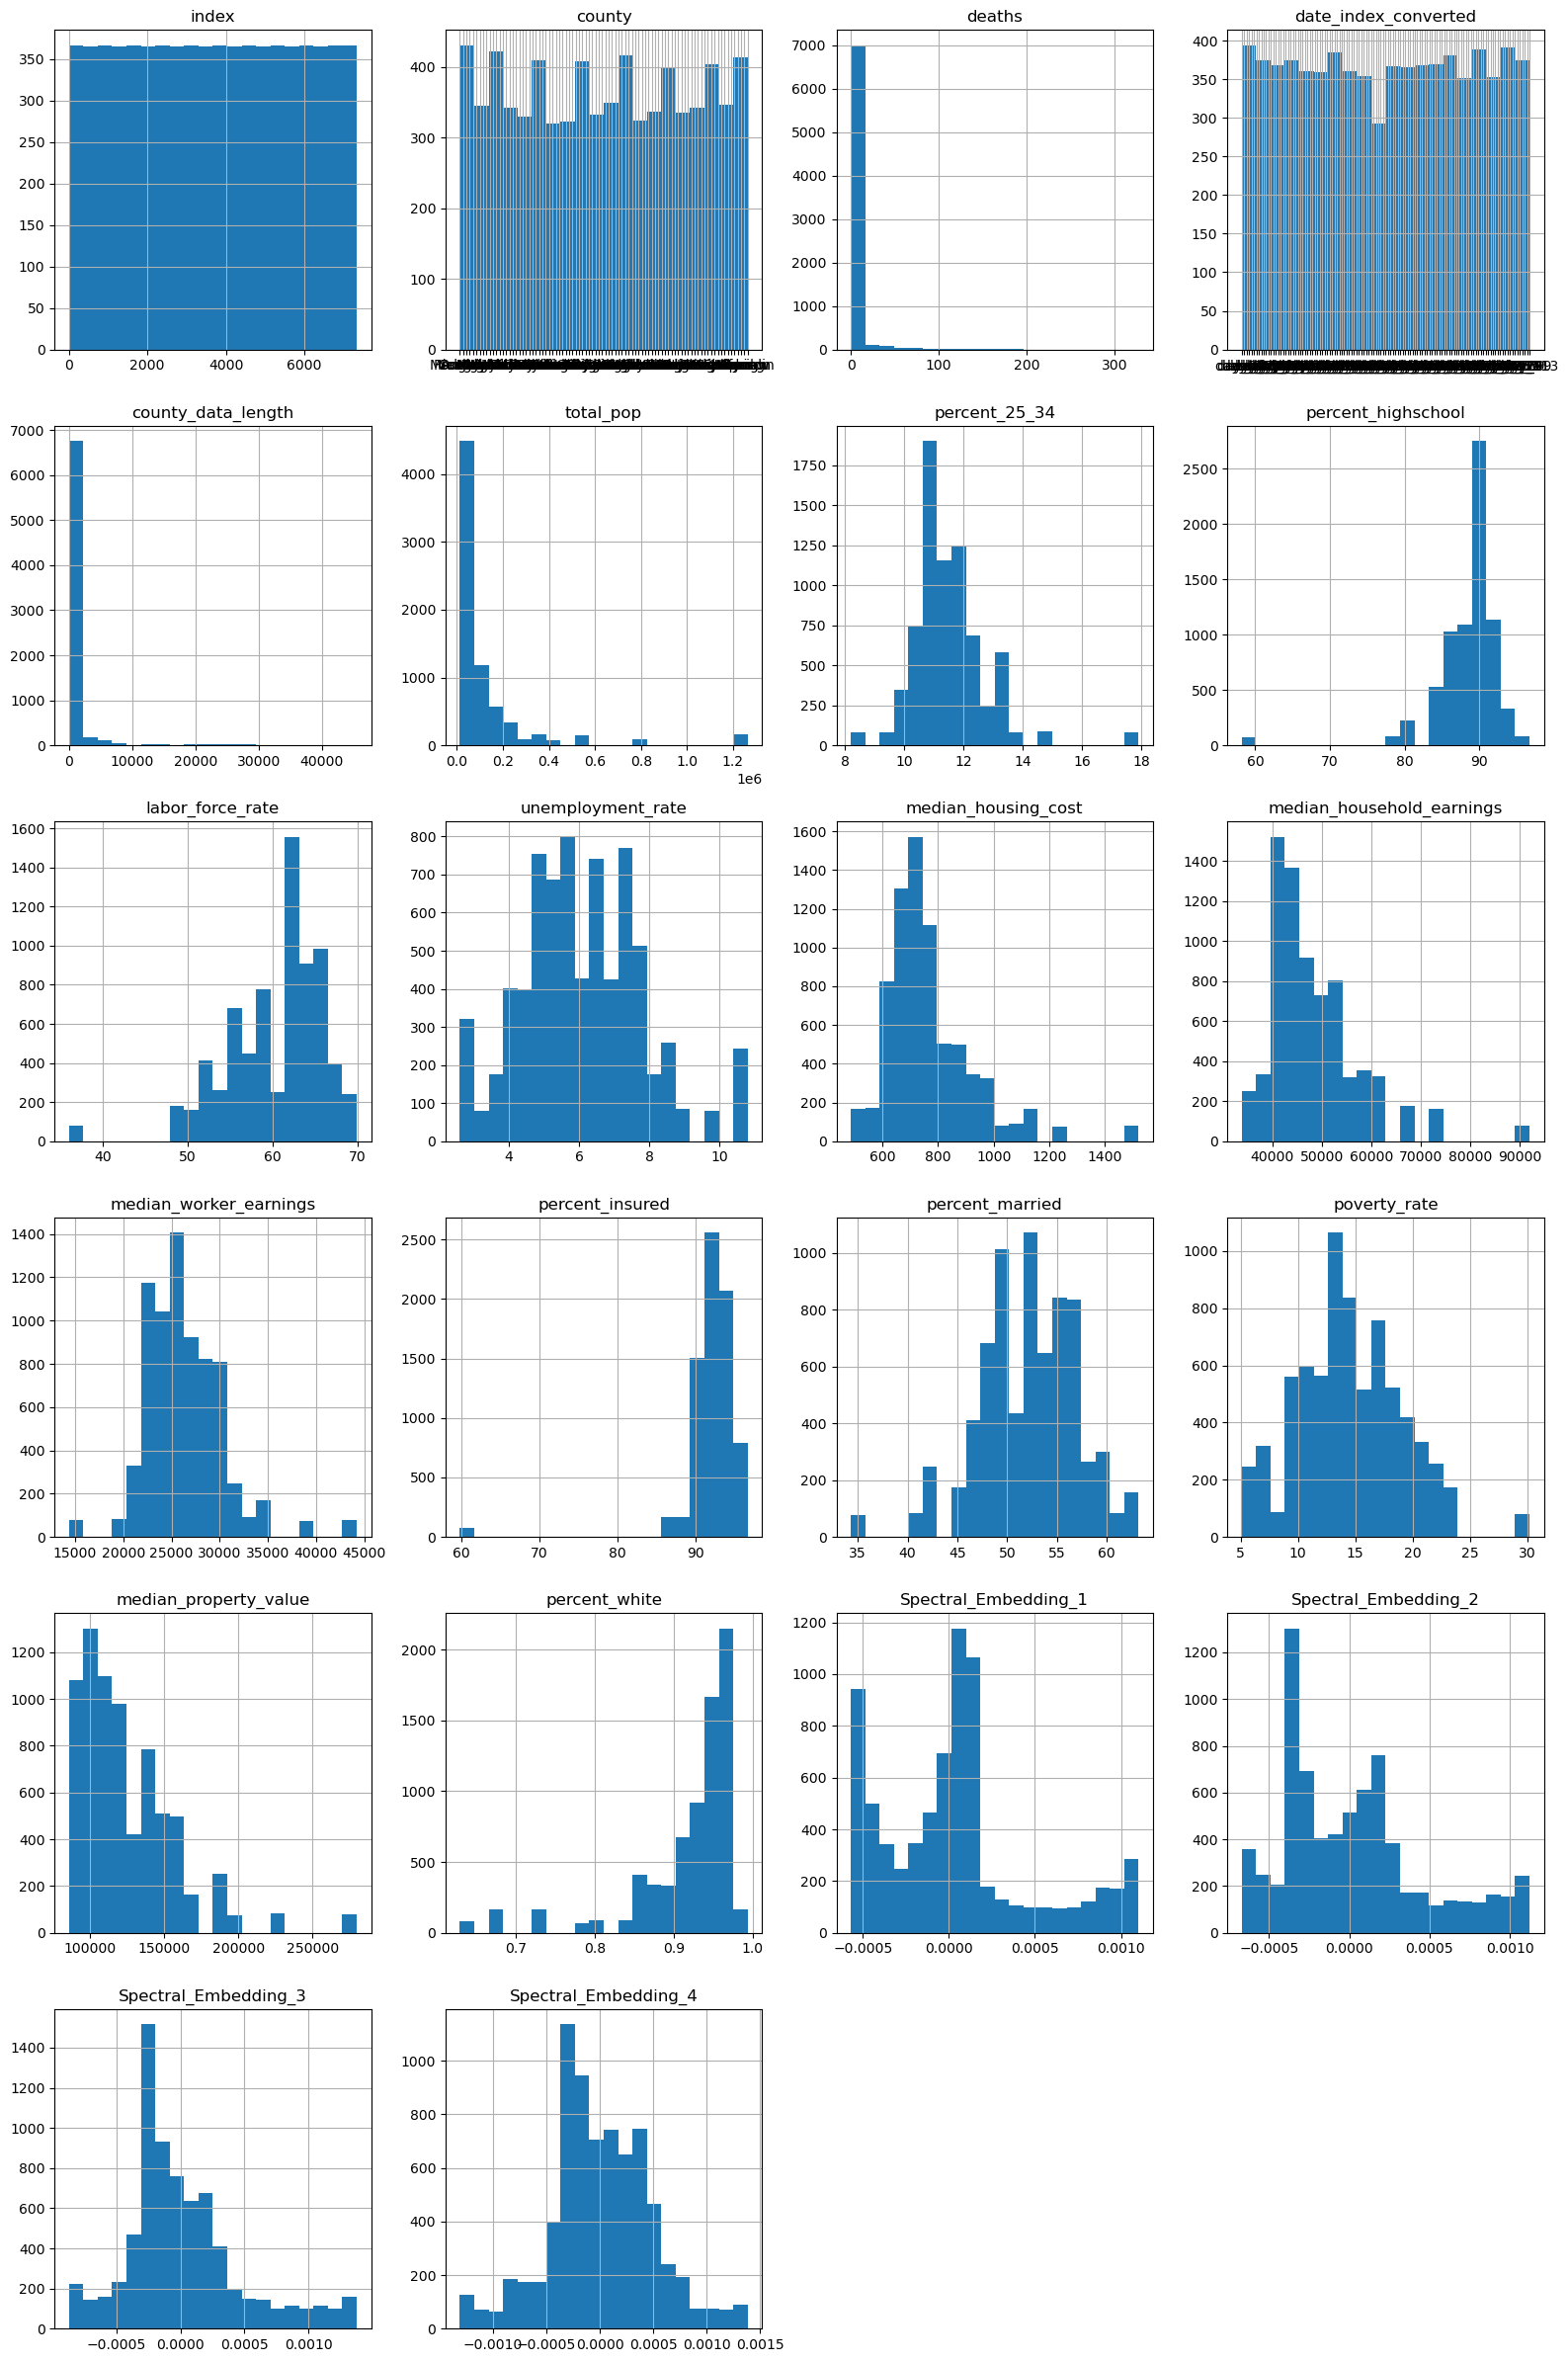

In [31]:
# STEP 12 --> Checking Distributions

# Number of variables in the DataFrame
n_vars = len(df_combined_test.columns)

# Number of rows and columns for the subplot grid
n_rows = int(np.ceil(n_vars / 4))
n_cols = 4

# Figure and axes for the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize = (16, n_rows * 4))

# Plotting histograms for each variable
for i, col in enumerate(df_combined_test.columns):
    ax = axes[i // n_cols, i % n_cols]
    df_combined_test[col].hist(ax = ax, bins = 20)
    ax.set_title(col)

# Hiding empty subplots
for i in range(n_vars, n_rows * n_cols):
    axes[i // n_cols, i % n_cols].axis('off')

# Displaying
plt.tight_layout()
plt.show() 

In [32]:
# STEP 13
# Dropping 'county' and 'date_index_converted' columns
df_combined_test = df_combined_test.drop(columns = ['county', 'date_index_converted'])
df_combined_test.head()

,index,deaths,county_data_length,total_pop,percent_25_34,percent_highschool,labor_force_rate,unemployment_rate,median_housing_cost,median_household_earnings,median_worker_earnings,percent_insured,percent_married,poverty_rate,median_property_value,percent_white,Spectral_Embedding_1,Spectral_Embedding_2,Spectral_Embedding_3,Spectral_Embedding_4
0,0,0,40,28361,9.7,88.2,58.2,4.7,713,47075,26589,88.5,56.9,14.8,116700,0.974052,-0.000397,-0.000254,-0.000084,0.000039
1,1,3,17,122312,12.1,86.9,55.5,7.5,675,41877,23210,90.5,48.3,15.6,103700,0.868085,0.001086,-0.000657,-0.000427,-0.000379
2,2,0,1210,161897,11.1,91.9,65.5,7.2,896,52552,25904,93.5,46.0,14.5,152000,0.909878,0.000094,0.000769,-0.000361,0.000113
3,3,0,38,45873,11.0,93.5,67.0,3.4,758,54274,30438,95.7,59.4,9.0,143100,0.970007,-0.000447,-0.000297,-0.000167,-0.000100
4,4,0,4328,533763,13.1,89.9,61.8,8.0,830,43829,26292,92.0,44.8,17.9,112100,0.731997,-0.000151,-0.000037,0.000247,0.000346


In [33]:
# STEP 14
# Preprocessing unseen dataframe df_test
X_test_unseen = df_combined_test.drop(columns = ['index'])

# Normalizing features of df_test
X_test_unseen_normalized = scaler_X.transform(X_test_unseen)

# Making predictions on unseen data
y_pred_unseen = predictive_model.predict(X_test_unseen_normalized)

# Inverse transforming predictions to original scale
y_pred_unseen_original = scaler_y.inverse_transform(y_pred_unseen.reshape(-1, 1)).flatten()

# New DataFrame with the index and predicted cases
df_predictive_model = pd.DataFrame({
    'index': df_combined_test['index'],
    'predicted_cases': y_pred_unseen_original
})

df_predictive_model.head()

,index,predicted_cases
0,0,7.803466
1,1,590.365356
2,2,14.407233
3,3,10.545154
4,4,37.673954


In [34]:
# STEP 15
# Renaming the columns
df_predictive_model.rename(columns = {'index': 'Index', 'predicted_cases': 'Cases'}, inplace = True)
df_predictive_model['Cases'] = df_predictive_model['Cases'].clip(lower = 0).astype(int)
df_predictive_model.to_csv('predictive_model.csv', index = False)
df_predictive_model.head()

,Index,Cases
0,0,7
1,1,590
2,2,14
3,3,10
4,4,37
